# Imports

In [1]:
from FOM import *
from ROM import *
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(0)

# Experiment parameters

In [2]:
# Total number of independent initial conditions sampled (training + testing)
Ns = 50
# Proportion of Ns to be set aside for testing
testFrac = 0.3
# Time horizon
Tf = 5
# Number of nodes in the spatial grid 
N = 30
# Indices of the resolved variables
indices = [5, 10, 15, 20, 25]
# FOM object
FO  = FOM(N=N)
# Indices of the unresolved variabless
tildeindices = [i for i in range(FO.N) if i not in indices]
# Tolerance for solve_ivp to generate full-state snapshots
tol = 1e-12

# Cases with time-invariant PDE parameters and zero forcing

## (a) Advection only
$\mu = 0, \quad v=1, \quad a=0$.

In [3]:
mu = 0
v  = 1
a  = 0

Generate full-state snapshots and partition them into training and testing sets. The outputs here are dense interpolants in time $t$.

In [4]:
trainIP, testIP = FO.create_grand_data_tensor(Ns, Tf, mu, a, v, test_size=testFrac, atol=tol)

### Full-memory

Reconstruct operators on a sample grid and predict resolved trajectories for unseen initial conditions.

In [5]:
# Build the time grid
dt = 1 / 2**4 
Nt = int(Tf / dt)
t_eval = np.linspace(0, Tf, Nt + 1)
# Full-state training snapshots on the grid
train = np.array([j(t_eval) for j in trainIP])
# Full-state testing snapshots on the grid
test = np.array([j(t_eval) for j in testIP])
# Split into resolved and unresolved variables
PhiTrain, PhiTildeTrain = FO.split_matrix_by_columns(train, indices)
PhiTest, PhiTildeTest   = FO.split_matrix_by_columns(test, indices)
# Time derrivative of the resolved variables via finite-differences
PhiTrainDeriv = 1/dt * (PhiTrain[:,:,1:] - PhiTrain[:,:,0:-1])
# ROM class
rom = ROM_Full_Data(PhiTrain, PhiTildeTrain, PhiTrainDeriv, dt, Ksolver="direct")
# Learn the operators
rom.train()
# Predict trajectories of the resolved variables for testing initial conditions
sol = rom.solve(PhiTest[:,:,0], PhiTildeTest[:,:,0])
# Compute relative L2 error
err = np.linalg.norm(sol - PhiTest)/np.linalg.norm(PhiTest)
print(err)

1.790901741360046e-11


Prediction with only the Markovian part

In [14]:
rom2 = ROM_Full_Data(PhiTrain, PhiTildeTrain, PhiTrainDeriv, dt, Ksolver="direct")
# Learn the operators
rom2.train(constantR=True)
rom2.K *= 0
rom2.B *= 0
# Predict trajectories of the resolved variables for testing initial conditions
sol2 = rom2.solve(PhiTest[:,:,0], PhiTildeTest[:,:,0])
print(np.linalg.norm(sol2 - PhiTest)/np.linalg.norm(PhiTest))

0.9523146811258527


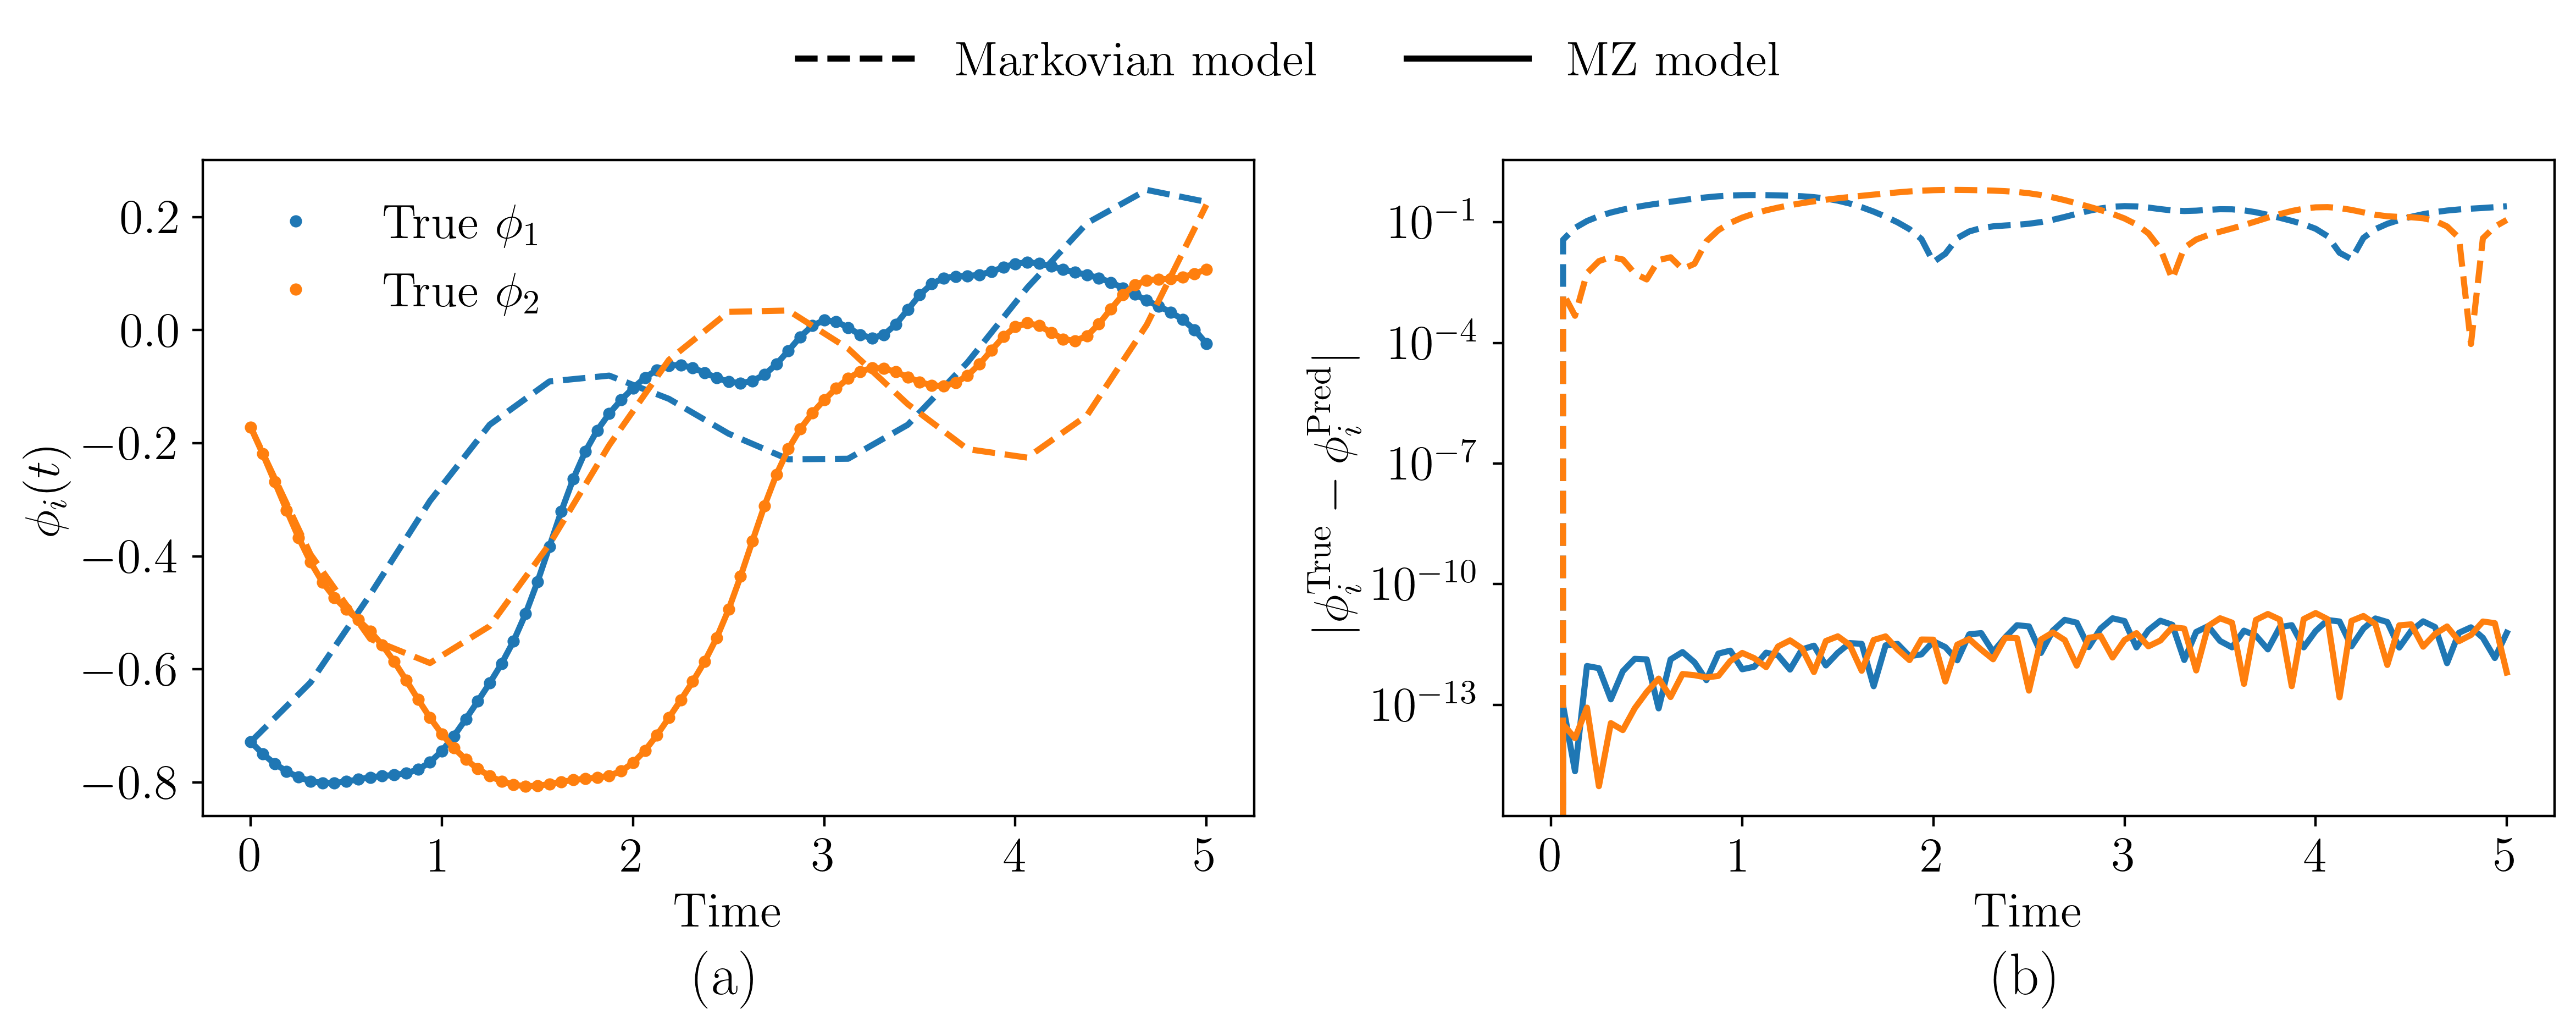

In [52]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

plt.rcParams.update(plt.rcParamsDefault)
plt.rc("figure", dpi=400)
plt.rc("font", size=16, family="serif")
plt.rc("legend", frameon=False)
plt.rc("text", usetex=True)
plt.rc("text.latex", preamble=r"\usepackage{amsmath}")
plt.rc("lines", linewidth=2)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

k = 2
idx = -2
colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]

# Panel (a)
for i in range(k):
    axes[0].plot(t_eval,      sol[idx, i, :],      color=colors[i], linestyle="-")                  # MZ
    axes[0].plot(t_eval,      PhiTest[idx, i, :],  color=colors[i], marker=".", linestyle="None")  # True
    axes[0].plot(t_eval[::5], sol2[idx, i, ::5],   color=colors[i], linestyle="--")                 # Markovian

axes[0].set_ylabel(r"$ \phi_i(t)$")
axes[0].set_xlabel(r"Time")

# Panel (b)
for i in range(k):
    err_mz = np.abs(PhiTest[idx, i, :] - sol[idx, i, :])
    err_mk = np.abs(PhiTest[idx, i, :] - sol2[idx, i, :])

    axes[1].semilogy(t_eval, err_mz, color=colors[i], linestyle="-")   # MZ
    axes[1].semilogy(t_eval, err_mk, color=colors[i], linestyle="--")  # Markovian

axes[1].set_ylabel(r"$|\phi_i^\text{True} - \phi_i^\text{Pred}|$")
axes[1].set_xlabel(r"Time")

# --- Legend handles ---
# Inside axes[0]: True φ1, True φ2 with colored markers
true_handles = [
    Line2D([0], [0], marker=".", linestyle="None", color=colors[i],
           label=rf"True $\phi_{{{i+1}}}$")
    for i in range(k)
]
axes[0].legend(handles=true_handles, loc="best")

# Top common legend: model styles (black)
h_mk = Line2D([0], [0], linestyle="--", color="k", label=r"Markovian model")
h_mz = Line2D([0], [0], linestyle="-",  color="k", label=r"MZ model")
fig.legend(handles=[h_mk, h_mz],
           loc="upper center", ncol=2,
           bbox_to_anchor=(0.5, 1.02),
           handlelength=2.5, columnspacing=1.8)

axes[0].set_title(r"(a)", y=-0.30)
axes[1].set_title(r"(b)", y=-0.30)
# Leave room for the top legend
fig.tight_layout(rect=[0, 0, 1, 0.92])

plt.show()
fig.savefig("data/FD_POD.pdf", format="pdf", bbox_inches="tight", dpi=400)


Repeat reconstruction and prediction on a sequence of time grids. Report errors in $\Phi$, $~R$, and $~K$. 

In [6]:
prev_errK = np.nan
prev_errR = np.nan
R_true = FO.R(0,mu,a,v,indices)

print(f"{'dt':>12} {'error in phi':>20} {'error in K':>20} {'Rate (K)':>20} {'error in R':>20} {'Rate (R)':>20}")
for i in range(0, 8):
    dt = 1 / 2**i
    Nt = int(Tf / dt)
    t_eval = np.linspace(0, Tf, Nt + 1)
    train = np.array([j(t_eval) for j in trainIP])
    test = np.array([j(t_eval) for j in testIP])
    PhiTrain, PhiTildeTrain = FO.split_matrix_by_columns(train, indices)
    PhiTest, PhiTildeTest   = FO.split_matrix_by_columns(test, indices)
    PhiTrainDeriv = 1/dt * (PhiTrain[:,:,1:] - PhiTrain[:,:,0:-1])

    rom = ROM_Full_Data(PhiTrain, PhiTildeTrain, PhiTrainDeriv, dt, Ksolver="direct")
    rom.train()

    sol = rom.solve(PhiTest[:,:,0], PhiTildeTest[:,:,0])
    err = np.linalg.norm(sol - PhiTest)/np.linalg.norm(PhiTest)

    K_true = FO.memory(t_eval[:-1], mu, a, v, indices)
    errK = np.linalg.norm(rom.K[:,:,1:] - K_true[:,:,1:])/ np.linalg.norm(K_true[:,:,1:])
    errR  = np.linalg.norm(rom.R[:,:,0] - R_true) / np.linalg.norm(R_true)

    ratio = np.log2(prev_errK / errK) if np.isfinite(prev_errK) else np.nan
    ratio2 = np.log2(prev_errR / errR) if np.isfinite(prev_errR) else np.nan
    
    print(f"{dt:12.7f} {err:20.2e} {errK:20.2e} {ratio:20.2f} {errR:20.2e} {ratio2:20.2f}")
    if err > 1e4:
        break
    prev_errK = errK
    prev_errR = errR

# For saving the solution later
sol1 = sol
t1 = t_eval
PhiTest1 = PhiTest
rom1 = rom

          dt         error in phi           error in K             Rate (K)           error in R             Rate (R)
   1.0000000             2.05e-11             1.00e+00                  nan             7.46e-01                  nan
   0.5000000             1.92e-11             1.04e+00                -0.05             3.61e+00                -2.28
   0.2500000             1.89e-11             1.54e+00                -0.57             1.79e+01                -2.31
   0.1250000             1.81e-11             7.83e-01                 0.97             4.25e-01                 5.39
   0.0625000             1.79e-11             1.88e-01                 2.06             7.79e-02                 2.45
   0.0312500             1.78e-11             4.57e-02                 2.04             1.82e-02                 2.09
   0.0156250             1.78e-11             1.13e-02                 2.01             4.49e-03                 2.02
   0.0078125             1.78e-11             2.83e-03  

Plot $||K(t)||_F$.

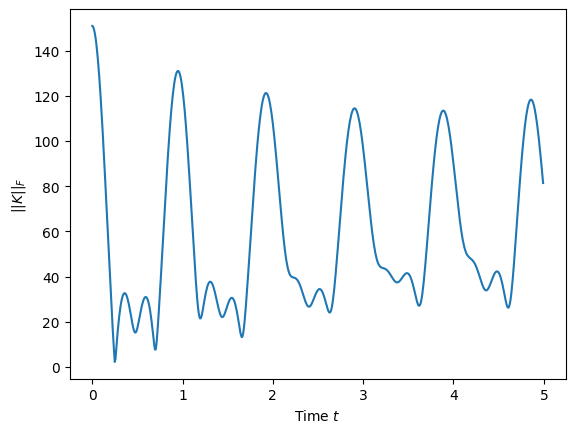

In [7]:
Knorms = [np.linalg.norm(rom.K[:,:,i]) for i in range(rom.K.shape[-1])]
plt.figure()
plt.plot(t_eval[:-1], Knorms)
plt.xlabel(r"Time $t$")
plt.ylabel(r"$||K||_F$")
plt.show()

### Finite-memory approximation

In [38]:
# Memory support truncation parameter
m = [1, 0.5, 0.3, 0.2, 0.1]
mLabels = [r"$100\%$", r"$50\%$", r"$30\%$", r"$20\%$", r"$10\%$"]
dt = 0.03125
Nt = int(Tf / dt)
t_eval = np.linspace(0, Tf, Nt + 1)
train = np.array([j(t_eval) for j in trainIP])
test = np.array([j(t_eval) for j in testIP])
PhiTrain, PhiTildeTrain = FO.split_matrix_by_columns(train, indices)
PhiTest, PhiTildeTest   = FO.split_matrix_by_columns(test, indices)
PhiTrainDeriv = 1/dt * (PhiTrain[:,:,1:] - PhiTrain[:,:,0:-1])

Memory support:  $100\%$ Error:  3.855765424155174e-09
Memory support:  $50\%$ Error:  0.020135422473344065
Memory support:  $30\%$ Error:  0.06595041778738481
Memory support:  $20\%$ Error:  0.061280055961089305
Memory support:  $10\%$ Error:  0.0464260107645073


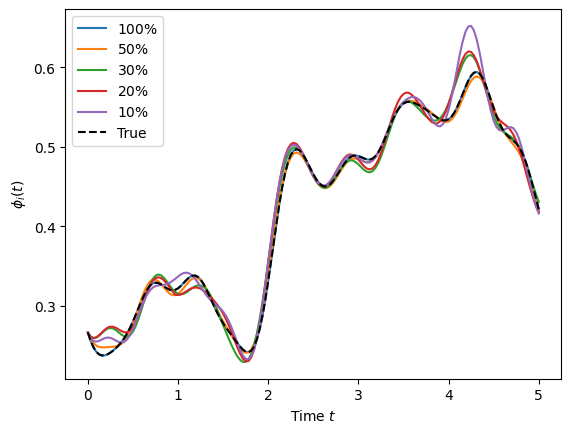

In [39]:
# ROM class with lsqr iterative solver
rom = ROM_Full_Data(PhiTrain, PhiTildeTrain, PhiTrainDeriv, dt, Ksolver="lsqr")
sol1_2 = []
plt.figure()
for i,h in enumerate(m):
    rom.train(memorySupport=h)
    sol = rom.solve(PhiTest[:,:,0], PhiTildeTest[:,:,0])
    sol1_2.append(sol)
    print(r"Memory support: ", mLabels[i], "Error: ", np.linalg.norm(sol - PhiTest)/np.linalg.norm(PhiTest))
    plt.plot(t_eval, sol[0][0], label=mLabels[i])
plt.plot(t_eval, PhiTest[0][0],"--k", label="True")
plt.legend()
plt.ylabel(r"$\phi_i(t)$")
plt.xlabel(r"Time $t$")
plt.show()

## (b) Advection dominated without reaction
$\mu = 0.1, \quad  v=1, \quad a = 0$.

In [10]:
mu = .1
v  = 1
a  = 0
trainIP, testIP = FO.create_grand_data_tensor(Ns, Tf, mu, a, v, test_size=testFrac, atol=1e-12)


### Full-memory

In [11]:
prev_errK = np.nan
prev_errR = np.nan
R_true = FO.R(0,mu,a,v,indices)

print(f"{'dt':>12} {'error in phi':>20} {'error in K':>20} {'Rate (K)':>20} {'error in R':>20} {'Rate (R)':>20}")
for i in range(0, 8):
    dt = 1 / 2**i
    Nt = int(Tf / dt)
    t_eval = np.linspace(0, Tf, Nt + 1)
    train = np.array([j(t_eval) for j in trainIP])
    test = np.array([j(t_eval) for j in testIP])
    PhiTrain, PhiTildeTrain = FO.split_matrix_by_columns(train, indices)
    PhiTest, PhiTildeTest   = FO.split_matrix_by_columns(test, indices)
    PhiTrainDeriv = 1/dt * (PhiTrain[:,:,1:] - PhiTrain[:,:,0:-1])

    rom = ROM_Full_Data(PhiTrain, PhiTildeTrain, PhiTrainDeriv, dt, Ksolver="direct")
    rom.train()

    sol = rom.solve(PhiTest[:,:,0], PhiTildeTest[:,:,0])
    err = np.linalg.norm(sol - PhiTest)/np.linalg.norm(PhiTest)

    K_true = FO.memory(t_eval[:-1], mu, a, v, indices)
    errK = np.linalg.norm(rom.K[:,:,1:] - K_true[:,:,1:])/ np.linalg.norm(K_true[:,:,1:])
    errR  = np.linalg.norm(rom.R[:,:,0] - R_true) / np.linalg.norm(R_true)

    ratio = np.log2(prev_errK / errK) if np.isfinite(prev_errK) else np.nan
    ratio2 = np.log2(prev_errR / errR) if np.isfinite(prev_errR) else np.nan
    
    print(f"{dt:12.7e} {err:20.2e} {errK:20.2e} {ratio:20.2f} {errR:20.2e} {ratio2:20.2f}")
    if err > 1e4:
        break
    prev_errK = errK
    prev_errR = errR

sol2 = sol
t2 = t_eval
PhiTest2 = PhiTest
rom2 = rom

          dt         error in phi           error in K             Rate (K)           error in R             Rate (R)
1.0000000e+00             2.00e-12             9.46e-01                  nan             7.43e-01                  nan
5.0000000e-01             1.78e-12             7.72e-01                 0.29             5.43e-01                 0.45
2.5000000e-01             1.74e-12             4.44e-01                 0.80             2.77e-01                 0.97
1.2500000e-01             1.70e-12             2.02e-01                 1.14             1.55e-01                 0.84
6.2500000e-02             1.70e-12             7.15e-02                 1.50             7.28e-02                 1.09
3.1250000e-02             1.70e-12             1.85e-02                 1.95             2.11e-02                 1.79
1.5625000e-02             1.71e-12             4.50e-03                 2.04             5.44e-03                 1.95
7.8125000e-03             1.69e-12             1.

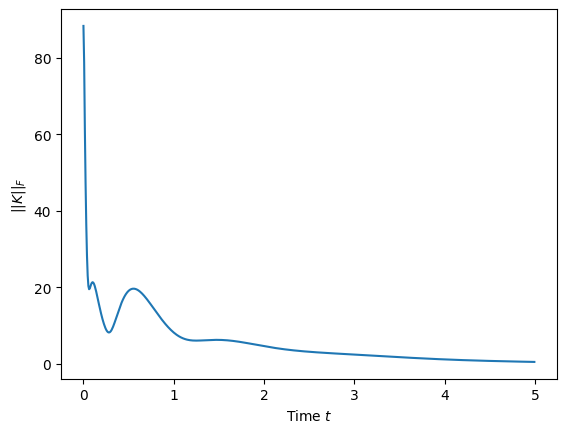

In [12]:
Knorms = [np.linalg.norm(rom.K[:,:,i]) for i in range(rom.K.shape[-1])]
plt.figure()
plt.plot(t_eval[:-1], Knorms)
plt.xlabel(r"Time $t$")
plt.ylabel(r"$||K||_F$")
plt.show()

### Finite-memory approximation

Memory support:  $100\%$ Error:  1.7013421606767515e-12
Memory support:  $50\%$ Error:  0.00244124196854252
Memory support:  $30\%$ Error:  0.007053872805674141
Memory support:  $20\%$ Error:  0.01094872176461491
Memory support:  $10\%$ Error:  0.011746481538876358


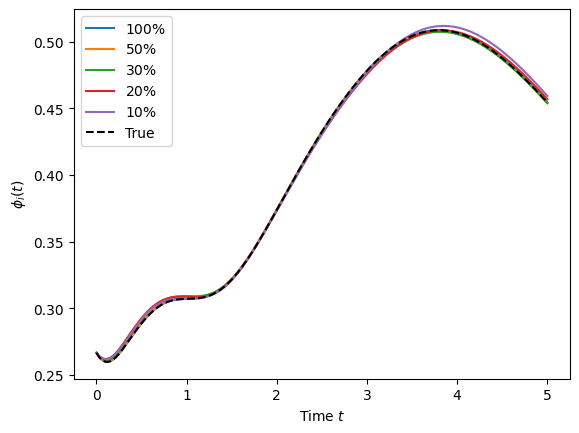

In [13]:
# Memory support truncation parameter
m = [1, 0.5, 0.3, 0.2, 0.1]
mLabels = [r"$100\%$", r"$50\%$", r"$30\%$", r"$20\%$", r"$10\%$"]
dt = 0.03125
Nt = int(Tf / dt)
t_eval = np.linspace(0, Tf, Nt + 1)
train = np.array([j(t_eval) for j in trainIP])
test = np.array([j(t_eval) for j in testIP])
PhiTrain, PhiTildeTrain = FO.split_matrix_by_columns(train, indices)
PhiTest, PhiTildeTest   = FO.split_matrix_by_columns(test, indices)
PhiTrainDeriv = 1/dt * (PhiTrain[:,:,1:] - PhiTrain[:,:,0:-1])

rom = ROM_Full_Data(PhiTrain, PhiTildeTrain, PhiTrainDeriv, dt, Ksolver="lsqr")
sol2_2 = []
plt.figure()
for i,h in enumerate(m):
    rom.train(memorySupport=h)
    sol = rom.solve(PhiTest[:,:,0], PhiTildeTest[:,:,0])
    sol2_2.append(sol)
    print(r"Memory support: ", mLabels[i], "Error: ", np.linalg.norm(sol - PhiTest)/np.linalg.norm(PhiTest))
    plt.plot(t_eval, sol[0][0], label=mLabels[i])
plt.plot(t_eval, PhiTest[0][0],"--k", label="True")
plt.legend()
plt.ylabel(r"$\phi_i(t)$")
plt.xlabel(r"Time $t$")
plt.show()

## (c) Reaction-diffusion-advection
$\mu = .05, \quad v=1, \quad a=1$

In [14]:
mu = 0.05
v  = 1
a  = 1
trainIP, testIP = FO.create_grand_data_tensor(Ns, Tf, mu, a, v, test_size=testFrac, atol=1e-12)

### Full-memory

In [15]:
prev_errK = np.nan
prev_errR = np.nan
R_true = FO.R(0,mu,a,v,indices)

print(f"{'dt':>12} {'error in phi':>20} {'error in K':>20} {'Rate (K)':>20} {'error in R':>20} {'Rate (R)':>20}")
for i in range(0, 9):
    dt = 1 / 2**i
    Nt = int(Tf / dt)
    t_eval = np.linspace(0, Tf, Nt + 1)
    train = np.array([j(t_eval) for j in trainIP])
    test = np.array([j(t_eval) for j in testIP])
    PhiTrain, PhiTildeTrain = FO.split_matrix_by_columns(train, indices)
    PhiTest, PhiTildeTest   = FO.split_matrix_by_columns(test, indices)
    PhiTrainDeriv = 1/dt * (PhiTrain[:,:,1:] - PhiTrain[:,:,0:-1])

    rom = ROM_Full_Data(PhiTrain, PhiTildeTrain, PhiTrainDeriv, dt, Ksolver="direct")
    rom.train()

    sol = rom.solve(PhiTest[:,:,0], PhiTildeTest[:,:,0])
    err = np.linalg.norm(sol - PhiTest)/np.linalg.norm(PhiTest)

    K_true = FO.memory(t_eval[:-1], mu, a, v, indices)
    errK = np.linalg.norm(rom.K[:,:,1:] - K_true[:,:,1:])/ np.linalg.norm(K_true[:,:,1:])
    errR  = np.linalg.norm(rom.R[:,:,0] - R_true) / np.linalg.norm(R_true)

    ratio = np.log2(prev_errK / errK) if np.isfinite(prev_errK) else np.nan
    ratio2 = np.log2(prev_errR / errR) if np.isfinite(prev_errR) else np.nan
    
    print(f"{dt:12.7e} {err:20.2e} {errK:20.2e} {ratio:20.2f} {errR:20.2e} {ratio2:20.2f}")
    if err > 1e4:
        break
    prev_errK = errK
    prev_errR = errR

sol3 = sol
t3 = t_eval
PhiTest3 = PhiTest
rom3 = rom

          dt         error in phi           error in K             Rate (K)           error in R             Rate (R)
1.0000000e+00             1.92e-12             1.11e+00                  nan             7.88e-01                  nan
5.0000000e-01             1.88e-12             1.01e+00                 0.15             1.27e+00                -0.69
2.5000000e-01             1.94e-12             4.36e-01                 1.21             1.08e+00                 0.24
1.2500000e-01             1.94e-12             1.07e-01                 2.03             5.40e-01                 1.00
6.2500000e-02             1.95e-12             2.63e-02                 2.02             1.26e-01                 2.10
3.1250000e-02             1.95e-12             6.56e-03                 2.00             3.06e-02                 2.04
1.5625000e-02             1.96e-12             1.64e-03                 2.00             7.59e-03                 2.01
7.8125000e-03             1.96e-12             4.

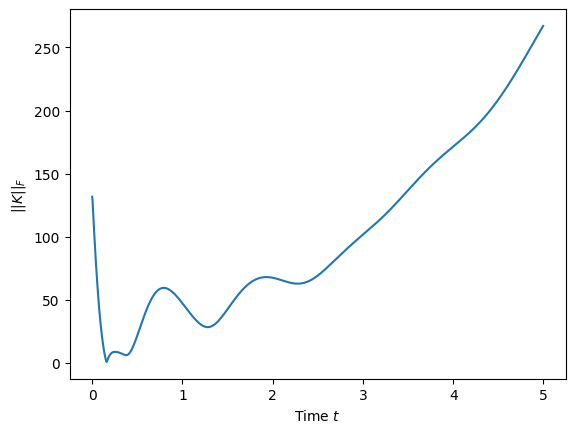

In [16]:
Knorms = [np.linalg.norm(rom.K[:,:,i]) for i in range(rom.K.shape[-1])]
plt.figure()
plt.plot(t_eval[:-1], Knorms)
plt.xlabel(r"Time $t$")
plt.ylabel(r"$||K||_F$")
plt.show()

### Finite-memory approximation

Memory support:  $100\%$ Error:  1.8642735537500992e-05
Memory support:  $50\%$ Error:  0.016167724607854417
Memory support:  $30\%$ Error:  0.047681337263881594
Memory support:  $20\%$ Error:  0.15957024305634335
Memory support:  $10\%$ Error:  0.2417616802067273


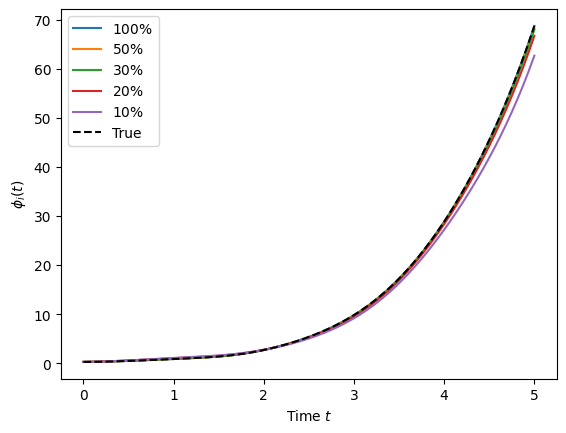

In [17]:
# Memory support truncation parameter
m = [1, 0.5, 0.3, 0.2, 0.1]
mLabels = [r"$100\%$", r"$50\%$", r"$30\%$", r"$20\%$", r"$10\%$"]
dt = 0.03125
Nt = int(Tf / dt)
t_eval = np.linspace(0, Tf, Nt + 1)
train = np.array([j(t_eval) for j in trainIP])
test = np.array([j(t_eval) for j in testIP])
PhiTrain, PhiTildeTrain = FO.split_matrix_by_columns(train, indices)
PhiTest, PhiTildeTest   = FO.split_matrix_by_columns(test, indices)
PhiTrainDeriv = 1/dt * (PhiTrain[:,:,1:] - PhiTrain[:,:,0:-1])

rom = ROM_Full_Data(PhiTrain, PhiTildeTrain, PhiTrainDeriv, dt, Ksolver="lsqr")
sol3_2 = []
plt.figure()
for i,h in enumerate(m):
    rom.train(memorySupport=h)
    sol = rom.solve(PhiTest[:,:,0], PhiTildeTest[:,:,0])
    sol3_2.append(sol)
    print(r"Memory support: ", mLabels[i], "Error: ", np.linalg.norm(sol - PhiTest)/np.linalg.norm(PhiTest))
    plt.plot(t_eval, sol[0][0], label=mLabels[i])
plt.plot(t_eval, PhiTest[0][0],"--k", label="True")
plt.legend()
plt.ylabel(r"$\phi_i(t)$")
plt.xlabel(r"Time $t$")
plt.show()

## (d) Diffusion dominated without reaction
$\mu = 2, \quad v=0.5, \quad a=0$

In [18]:
mu = 2
v  = 0.5
a  = 0
trainIP, testIP = FO.create_grand_data_tensor(Ns, Tf, mu, a, v, test_size=testFrac, atol=1e-12)

### Full-memory

In [19]:
prev_errK = np.nan
prev_errR = np.nan
R_true = FO.R(0,mu,a,v,indices)

print(f"{'dt':>12} {'error in phi':>20} {'error in K':>20} {'Rate (K)':>20} {'error in R':>20} {'Rate (R)':>20}")
for i in range(5, 12):
    dt = 1 / 2**i
    Nt = int(Tf / dt)
    t_eval = np.linspace(0, Tf, Nt + 1)
    train = np.array([j(t_eval) for j in trainIP])
    test = np.array([j(t_eval) for j in testIP])
    PhiTrain, PhiTildeTrain = FO.split_matrix_by_columns(train, indices)
    PhiTest, PhiTildeTest   = FO.split_matrix_by_columns(test, indices)
    PhiTrainDeriv = 1/dt * (PhiTrain[:,:,1:] - PhiTrain[:,:,0:-1])

    rom = ROM_Full_Data(PhiTrain, PhiTildeTrain, PhiTrainDeriv, dt, Ksolver="direct")
    rom.train()

    sol = rom.solve(PhiTest[:,:,0], PhiTildeTest[:,:,0])
    err = np.linalg.norm(sol - PhiTest)/np.linalg.norm(PhiTest)

    K_true = FO.memory(t_eval[:-1], mu, a, v, indices)
    errK = np.linalg.norm(rom.K[:,:,1:] - K_true[:,:,1:])/ np.linalg.norm(K_true[:,:,1:])
    errR  = np.linalg.norm(rom.R[:,:,0] - R_true) / np.linalg.norm(R_true)

    ratio = np.log2(prev_errK / errK) if np.isfinite(prev_errK) else np.nan
    ratio2 = np.log2(prev_errR / errR) if np.isfinite(prev_errR) else np.nan
    
    print(f"{dt:12.7e} {err:20.2e} {errK:20.2e} {ratio:20.2f} {errR:20.2e} {ratio2:20.2f}")
    if err > 1e4:
        break
    prev_errK = errK
    prev_errR = errR

sol4 = sol
t4 = t_eval
PhiTest4 = PhiTest
rom4 = rom

          dt         error in phi           error in K             Rate (K)           error in R             Rate (R)
3.1250000e-02             4.64e-12             5.04e-01                  nan             6.84e-01                  nan
1.5625000e-02             4.63e-12             3.01e-01                 0.75             4.76e-01                 0.52
7.8125000e-03             4.62e-12             1.50e-01                 1.00             2.42e-01                 0.98
3.9062500e-03             4.62e-12             5.65e-02                 1.41             8.53e-02                 1.50
1.9531250e-03             4.62e-12             1.71e-02                 1.73             2.39e-02                 1.83
9.7656250e-04             4.63e-12             4.64e-03                 1.88             6.18e-03                 1.95
4.8828125e-04             4.63e-12             1.20e-03                 1.95             1.56e-03                 1.99


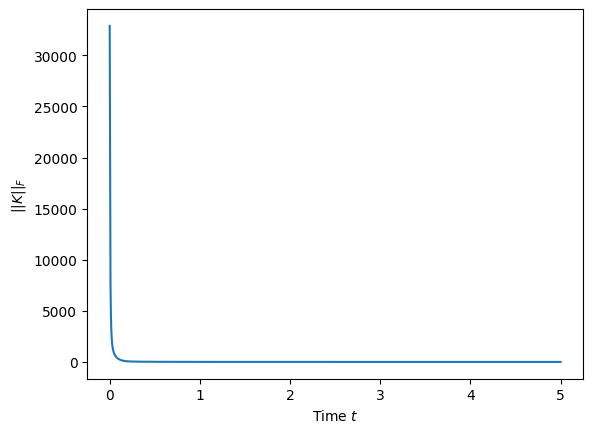

In [20]:
Knorms = [np.linalg.norm(rom.K[:,:,i]) for i in range(rom.K.shape[-1])]
plt.figure()
plt.plot(t_eval[:-1], Knorms)
plt.xlabel(r"Time $t$")
plt.ylabel(r"$||K||_F$")
plt.show()

### Finite-memory approximation

In [ ]:
# Memory support truncation parameter
m = [1, 0.5, 0.3, 0.2, 0.1]
mLabels = [r"$100\%$", r"$50\%$", r"$30\%$", r"$20\%$", r"$10\%$"]
dt = 0.03125
Nt = int(Tf / dt)
t_eval = np.linspace(0, Tf, Nt + 1)
train = np.array([j(t_eval) for j in trainIP])
test = np.array([j(t_eval) for j in testIP])
PhiTrain, PhiTildeTrain = FO.split_matrix_by_columns(train, indices)
PhiTest, PhiTildeTest   = FO.split_matrix_by_columns(test, indices)
PhiTrainDeriv = 1/dt * (PhiTrain[:,:,1:] - PhiTrain[:,:,0:-1])

rom = ROM_Full_Data(PhiTrain, PhiTildeTrain, PhiTrainDeriv, dt, Ksolver="lsqr")
sol4_2 = []
plt.figure()
for i,h in enumerate(m):
    rom.train(memorySupport=h)
    sol = rom.solve(PhiTest[:,:,0], PhiTildeTest[:,:,0])
    sol4_2.append(sol)
    print(r"Memory support: ", mLabels[i], "Error: ", np.linalg.norm(sol - PhiTest)/np.linalg.norm(PhiTest))
    plt.plot(t_eval, sol[0][0], label=mLabels[i])
plt.plot(t_eval, PhiTest[0][0],"--k", label="True")
plt.legend()
plt.ylabel(r"$\phi_i(t)$")
plt.xlabel(r"Time $t$")
plt.show()

# Cases with time-varying PDE parameters and zero forcing

##  (e) Time-depedent reaction-diffusion-advection
$\mu = 0.01\cos^2(2t), \quad v=1 + \sin^2(5t), \quad a=-0.5\cos t$

In [22]:
mu = lambda t: 0.01*np.cos(2*t)**2
v  = lambda t: 1 + np.sin(5*t)**2
a  = lambda t: -0.5*np.cos(t)

trainIP, testIP = FO.create_grand_data_tensor(Ns, Tf, mu, a, v, test_size=testFrac, atol=1e-12)

### Full-memory

In [23]:
prev_errK = np.nan
prev_errR = np.nan

imin, imax = 5, 9

# will hold rom.K from the finest grid
K_true_fine = None  

print(f"{'dt':>12} {'error in phi':>20} {'error in K':>20} {'Rate (K)':>20} {'error in R':>20} {'Rate (R)':>20}")

for i in range(imax, imin - 1, -1):
    dt = 1 / 2**i
    Nt = int(Tf / dt)
    t_eval = np.linspace(0, Tf, Nt + 1)

    # Build training/testing snapshots on this grid
    train = np.array([j(t_eval) for j in trainIP])
    test  = np.array([j(t_eval) for j in testIP])

    PhiTrain, PhiTildeTrain = FO.split_matrix_by_columns(train, indices)
    PhiTest,  PhiTildeTest  = FO.split_matrix_by_columns(test,  indices)

    PhiTrainDeriv = (PhiTrain[:, :, 1:] - PhiTrain[:, :, :-1]) / dt

    # Train ROM on this grid
    rom = ROM_Full_Data(PhiTrain, PhiTildeTrain, PhiTrainDeriv, dt, Ksolver="direct")
    rom.train(constantR=False)

    # Solve on test inputs
    sol  = rom.solve(PhiTest[:, :, 0], PhiTildeTest[:, :, 0])
    err  = np.linalg.norm(sol - PhiTest) / np.linalg.norm(PhiTest)

    # Construct R_true on midpoints for this grid
    R_true = np.zeros_like(rom.R)
    for j in range(len(t_eval) - 1):
        t = 0.5 * (t_eval[j] + t_eval[j + 1])
        R_true[:, :, j] = FO.R(t, mu, a, v, indices)

    # Build K_true for this grid from the finest-grid ROM
    if K_true_fine is None:
        # Finest grid: set truth directly
        K_true_fine = rom.K.copy()
        K_true = K_true_fine
        errK = 0.0  # identical by construction on the finest grid
    else:
        # Coarser grids: subsample the finest-grid truth
        stride = 2 ** (imax - i)  # dyadic stride from finest to current
        K_true = K_true_fine[..., ::stride]

        # Fallback if off-by-one occurs due to endpoint conventions
        if K_true.shape[2] != rom.K.shape[2]:
            idx = np.round(
                np.linspace(0, K_true_fine.shape[2] - 1, rom.K.shape[2])
            ).astype(int)
            K_true = K_true_fine[..., idx]

        if rom.K.shape != K_true.shape:
            raise ValueError(f"K shape mismatch: rom.K {rom.K.shape} vs K_true {K_true.shape}")

        errK = np.linalg.norm(rom.K - K_true) / np.linalg.norm(K_true)

    # Error in R on midpoints
    errR = np.linalg.norm(rom.R - R_true) / np.linalg.norm(R_true)

    # Convergence rates
    ratioK = np.log2(prev_errK / errK) if np.isfinite(prev_errK) and errK > 0 else np.nan
    ratioR = np.log2(prev_errR / errR) if np.isfinite(prev_errR) and errR > 0 else np.nan

    print(f"{dt:12.7e} {err:20.2e} {errK:20.2e} {ratioK:20.2f} {errR:20.2e} {ratioR:20.2f}")

    if err > 1e4:
        break

    prev_errK = errK
    prev_errR = errR

# Keep last objects if needed downstream
sol5 = sol
t5 = t_eval
PhiTest5 = PhiTest
rom5 = rom


          dt         error in phi           error in K             Rate (K)           error in R             Rate (R)
1.9531250e-03             1.13e-11             0.00e+00                  nan             2.14e-04                  nan


/var/folders/30/0jwhyzsj0rnb88s_49hf9shm0000gq/T/ipykernel_56816/3722840870.py:66: RuntimeWarning: divide by zero encountered in log2
  ratioK = np.log2(prev_errK / errK) if np.isfinite(prev_errK) and errK > 0 else np.nan


3.9062500e-03             1.13e-11             7.64e-04                 -inf             8.56e-04                -2.00
7.8125000e-03             1.13e-11             3.73e-03                -2.29             3.43e-03                -2.00
1.5625000e-02             1.13e-11             1.52e-02                -2.03             1.39e-02                -2.02
3.1250000e-02             1.12e-11             5.86e-02                -1.95             5.88e-02                -2.08


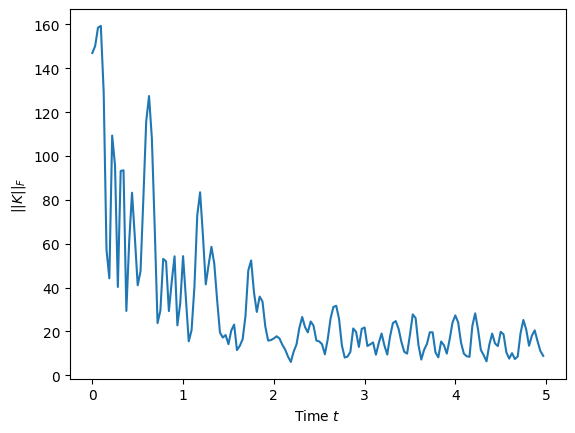

In [24]:
Knorms = [np.linalg.norm(rom.K[:,:,i]) for i in range(rom.K.shape[-1])]
plt.figure()
plt.plot(t_eval[:-1], Knorms)
plt.xlabel(r"Time $t$")
plt.ylabel(r"$||K||_F$")
plt.show()

### Finite-memory approximation

Memory support:  $100\%$ Error:  1.2181248034389704e-11
Memory support:  $50\%$ Error:  0.01780655111372982
Memory support:  $30\%$ Error:  0.01677801762883804
Memory support:  $20\%$ Error:  0.03392818085247466
Memory support:  $10\%$ Error:  0.022706360305842232


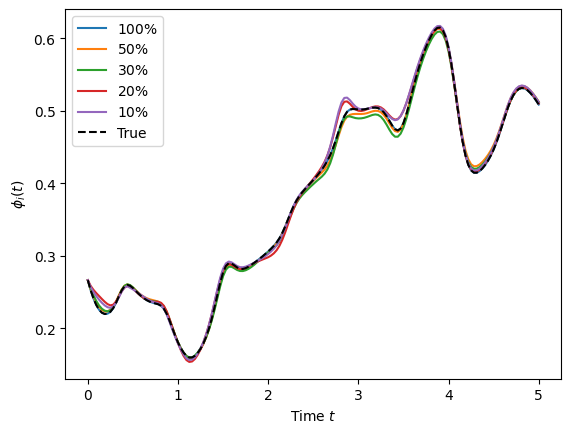

In [25]:
# Memory support truncation parameter
m = [1, 0.5, 0.3, 0.2, 0.1]
mLabels = [r"$100\%$", r"$50\%$", r"$30\%$", r"$20\%$", r"$10\%$"]
dt = 0.03125
Nt = int(Tf / dt)
t_eval = np.linspace(0, Tf, Nt + 1)
train = np.array([j(t_eval) for j in trainIP])
test = np.array([j(t_eval) for j in testIP])
PhiTrain, PhiTildeTrain = FO.split_matrix_by_columns(train, indices)
PhiTest, PhiTildeTest   = FO.split_matrix_by_columns(test, indices)
PhiTrainDeriv = 1/dt * (PhiTrain[:,:,1:] - PhiTrain[:,:,0:-1])

rom = ROM_Full_Data(PhiTrain, PhiTildeTrain, PhiTrainDeriv, dt, Ksolver="lsqr")
sol5_2 = []
plt.figure()
for i,h in enumerate(m):
    rom.train(constantR=False, memorySupport=h)
    sol = rom.solve(PhiTest[:,:,0], PhiTildeTest[:,:,0])
    sol5_2.append(sol)
    print(r"Memory support: ", mLabels[i], "Error: ", np.linalg.norm(sol - PhiTest)/np.linalg.norm(PhiTest))
    plt.plot(t_eval, sol[0][0], label=mLabels[i])
plt.plot(t_eval, PhiTest[0][0],"--k", label="True")
plt.legend()
plt.ylabel(r"$\phi_i(t)$")
plt.xlabel(r"Time $t$")
plt.show()

## (f) Time-dependent reaction-advection
$\mu = 0, \quad v= 0.5 + \sin(4t),\quad  a=\cos(5t)^2,$

In [26]:
mu = 0
v  = lambda t: 0.5 + np.sin(4*t)
a  = lambda t: np.cos(5*t)**2
trainIP, testIP = FO.create_grand_data_tensor(Ns, Tf, mu, a, v, test_size=testFrac, atol=1e-12)

### Full-memory

In [27]:
prev_errK = np.nan
prev_errR = np.nan

imin, imax = 5, 9
K_true_fine = None 

print(f"{'dt':>12} {'error in phi':>20} {'error in K':>20} {'Rate (K)':>20} {'error in R':>20} {'Rate (R)':>20}")

for i in range(imax, imin - 1, -1):  # 10, 9, ..., 0
    dt = 1 / 2**i
    Nt = int(Tf / dt)
    t_eval = np.linspace(0, Tf, Nt + 1)

    # Build training/testing snapshots on this grid
    train = np.array([j(t_eval) for j in trainIP])
    test  = np.array([j(t_eval) for j in testIP])

    PhiTrain, PhiTildeTrain = FO.split_matrix_by_columns(train, indices)
    PhiTest,  PhiTildeTest  = FO.split_matrix_by_columns(test,  indices)

    PhiTrainDeriv = (PhiTrain[:, :, 1:] - PhiTrain[:, :, :-1]) / dt

    # Train ROM on this grid
    rom = ROM_Full_Data(PhiTrain, PhiTildeTrain, PhiTrainDeriv, dt, Ksolver="direct")
    rom.train(constantR=False)

    # Solve on test inputs
    sol  = rom.solve(PhiTest[:, :, 0], PhiTildeTest[:, :, 0])
    err  = np.linalg.norm(sol - PhiTest) / np.linalg.norm(PhiTest)

    # Construct R_true on midpoints for this grid
    R_true = np.zeros_like(rom.R)
    for j in range(len(t_eval) - 1):
        t = 0.5 * (t_eval[j] + t_eval[j + 1])
        R_true[:, :, j] = FO.R(t, mu, a, v, indices)

    # Build K_true for this grid from the finest-grid ROM
    if K_true_fine is None:
        # Finest grid: set truth directly
        K_true_fine = rom.K.copy()
        K_true = K_true_fine
        errK = 0.0  # identical by construction on the finest grid
    else:
        # Coarser grids: subsample the finest-grid truth
        stride = 2 ** (imax - i)  # dyadic stride from finest to current
        K_true = K_true_fine[..., ::stride]

        # Fallback if off-by-one occurs due to endpoint conventions
        if K_true.shape[2] != rom.K.shape[2]:
            idx = np.round(
                np.linspace(0, K_true_fine.shape[2] - 1, rom.K.shape[2])
            ).astype(int)
            K_true = K_true_fine[..., idx]

        if rom.K.shape != K_true.shape:
            raise ValueError(f"K shape mismatch: rom.K {rom.K.shape} vs K_true {K_true.shape}")

        errK = np.linalg.norm(rom.K - K_true) / np.linalg.norm(K_true)

    # Error in R on midpoints
    errR = np.linalg.norm(rom.R - R_true) / np.linalg.norm(R_true)

    # Convergence rates
    ratioK = np.log2(prev_errK / errK) if np.isfinite(prev_errK) and errK > 0 else np.nan
    ratioR = np.log2(prev_errR / errR) if np.isfinite(prev_errR) and errR > 0 else np.nan

    print(f"{dt:12.7e} {err:20.2e} {errK:20.2e} {ratioK:20.2f} {errR:20.2e} {ratioR:20.2f}")

    if err > 1e4:
        break

    prev_errK = errK
    prev_errR = errR


sol6 = sol
t6 = t_eval
PhiTest6 = PhiTest
rom6 = rom

          dt         error in phi           error in K             Rate (K)           error in R             Rate (R)
1.9531250e-03             1.35e-11             0.00e+00                  nan             1.05e-04                  nan


/var/folders/30/0jwhyzsj0rnb88s_49hf9shm0000gq/T/ipykernel_56816/3631026243.py:64: RuntimeWarning: divide by zero encountered in log2
  ratioK = np.log2(prev_errK / errK) if np.isfinite(prev_errK) and errK > 0 else np.nan


3.9062500e-03             1.35e-11             1.44e-03                 -inf             4.22e-04                -2.00
7.8125000e-03             1.36e-11             7.14e-03                -2.31             1.69e-03                -2.00
1.5625000e-02             1.36e-11             2.93e-02                -2.04             6.82e-03                -2.01
3.1250000e-02             1.37e-11             1.08e-01                -1.89             2.81e-02                -2.04


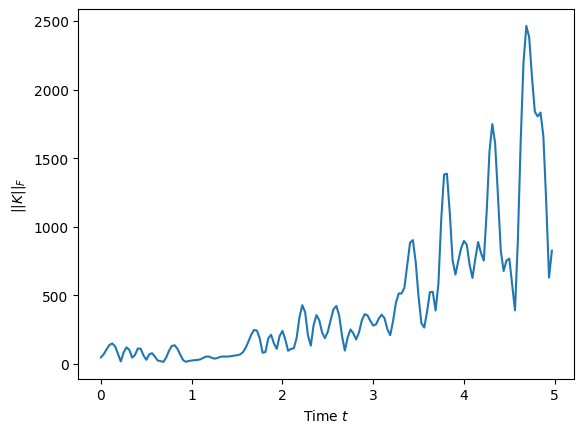

In [28]:
Knorms = [np.linalg.norm(rom.K[:,:,i]) for i in range(rom.K.shape[-1])]
plt.figure()
plt.plot(t_eval[:-1], Knorms)
plt.xlabel(r"Time $t$")
plt.ylabel(r"$||K||_F$")
plt.show()

### Finite-memory approximation

Memory support:  $100\%$ Error:  0.0045741848677363405
Memory support:  $50\%$ Error:  115.10581488246258
Memory support:  $30\%$ Error:  134.90813091305895
Memory support:  $20\%$ Error:  7369.9167466124045
Memory support:  $10\%$ Error:  1232.9384747488887


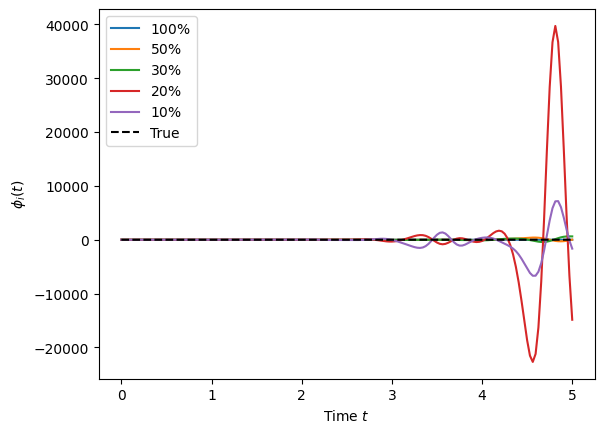

In [29]:
# Memory support truncation parameter
m = [1, 0.5, 0.3, 0.2, 0.1]
mLabels = [r"$100\%$", r"$50\%$", r"$30\%$", r"$20\%$", r"$10\%$"]
dt = 0.03125
Nt = int(Tf / dt)
t_eval = np.linspace(0, Tf, Nt + 1)
train = np.array([j(t_eval) for j in trainIP])
test = np.array([j(t_eval) for j in testIP])
PhiTrain, PhiTildeTrain = FO.split_matrix_by_columns(train, indices)
PhiTest, PhiTildeTest   = FO.split_matrix_by_columns(test, indices)
PhiTrainDeriv = 1/dt * (PhiTrain[:,:,1:] - PhiTrain[:,:,0:-1])

rom = ROM_Full_Data(PhiTrain, PhiTildeTrain, PhiTrainDeriv, dt, Ksolver="lsqr", maxiter=500)
sol6_2 = []
plt.figure()
for i,h in enumerate(m):
    rom.train(constantR=False, memorySupport=h)
    sol = rom.solve(PhiTest[:,:,0], PhiTildeTest[:,:,0])
    sol6_2.append(sol)
    print(r"Memory support: ", mLabels[i], "Error: ", np.linalg.norm(sol - PhiTest)/np.linalg.norm(PhiTest))
    plt.plot(t_eval, sol[0][0], label=mLabels[i])
plt.plot(t_eval, PhiTest[0][0],"--k", label="True")
plt.legend()
plt.ylabel(r"$\phi_i(t)$")
plt.xlabel(r"Time $t$")
plt.show()

# Cases with non-zero forcing

## (g) Constant diffusion with forcing

In [30]:
mu = 2
v  = 0
a  = 0
trainIP, testIP = FO.create_grand_data_tensor(Ns, Tf, mu, a, v, test_size=testFrac, atol=1e-12, forcing="rank1")

### Full-memory

In [31]:
prev_errK = np.nan
prev_errR = np.nan
R_true = FO.R(0,mu,a,v,indices)


print(f"{'dt':>12} {'error in phi':>20} {'error in K':>20} {'Rate (K)':>20} {'error in R':>20} {'Rate (R)':>20}")
for i in range(5, 12):
    dt = 1 / 2 ** i
    Nt = int(Tf / dt)
    t_eval = np.linspace(0, Tf, Nt + 1)
    t_half = t_eval[1:]/2 + t_eval[:-1]/2
    train = np.array([j(t_eval) for j in trainIP])
    test = np.array([j(t_eval) for j in testIP])
    PhiTrain, PhiTildeTrain = FO.split_matrix_by_columns(train, indices)
    PhiTest, PhiTildeTest   = FO.split_matrix_by_columns(test, indices)
    PhiTrainDeriv = 1/dt * (PhiTrain[:,:,1:] - PhiTrain[:,:,0:-1])

    # Forcing term matrices
    Gbar = np.array([[FO.f(train[i,:,0], "rank1")(t_) for t_ in t_eval[:-1]] for i in range(train.shape[0])]).transpose(0,2,1)
    GbarTest = np.array([[FO.f(test[i,:,0], "rank1")(t_) for t_ in t_eval[:-1]] for i in range(test.shape[0])]).transpose(0,2,1)
    Gbar2 = np.array([[FO.f(train[i,:,0], "rank1")(t_) for t_ in t_half] for i in range(train.shape[0])]).transpose(0,2,1)
    GbarTest2 = np.array([[FO.f(test[i,:,0], "rank1")(t_) for t_ in t_half] for i in range(test.shape[0])]).transpose(0,2,1)

    
    

    G, _ = FO.split_matrix_by_columns(Gbar2, indices)
    _, GTilde = FO.split_matrix_by_columns(Gbar, indices)
    GTest, _ = FO.split_matrix_by_columns(GbarTest2, indices)
    _, GTildeTest = FO.split_matrix_by_columns(GbarTest, indices)



    rom = ROM_Full_Data_Forcing(PhiTrain, PhiTildeTrain, PhiTrainDeriv, G, GTilde, dt)
    rom.train(constantR=True)

    sol = rom.solve(PhiTest[:,:,0], PhiTildeTest[:,:,0], GTest, GTildeTest)
    err = np.linalg.norm(sol - PhiTest)/np.linalg.norm(PhiTest)

    R_true = np.zeros_like(rom.R)
    for j in range(len(t_eval)-1):
        t = t_eval[j]/2 + t_eval[j+1]/2
        R_true[:,:,j] = FO.R(t,mu,a,v,indices)

    K_true = np.array([
        FO.RTilde(t_,mu,a,v,indices)@expm(FO.R(t_,mu,a,v,tildeindices)*t_)@FO.RTilde(t_,mu,a,v,tildeindices) for t_ in t_eval[:-1]
    ]).transpose(1,2,0)
    B_true = np.array([
        FO.RTilde(t_,mu,a,v,indices)@expm(FO.R(t_,mu,a,v,tildeindices)*t_) for t_ in t_half
    ]).transpose(1,2,0)
    # errB = np.linalg.norm(rom.B[:,:,1:] - B_true[:,:,1:])/ np.linalg.norm(B_true[:,:,1:])
    # print(errB)
    
    errK =  np.linalg.norm(rom.K[:,:,1:] - K_true[:,:,1:])/ np.linalg.norm(K_true[:,:,1:])
    errR  = np.linalg.norm(rom.R - R_true) / np.linalg.norm(R_true)

    ratio = np.log2(prev_errK / errK) if np.isfinite(prev_errK) else np.nan
    ratio2 = np.log2(prev_errR / errR) if np.isfinite(prev_errR) else np.nan
    
    print(f"{dt:12.7e} {err:20.2e} {errK:20.2e} {ratio:20.2f} {errR:20.2e} {ratio2:20.2f}")
    if err > 1e4:
        break
    prev_errK = errK
    prev_errR = errR

sol7 = sol
t7 = t_eval
PhiTest7 = PhiTest
rom7= rom

          dt         error in phi           error in K             Rate (K)           error in R             Rate (R)
3.1250000e-02             4.19e-12             5.04e-01                  nan             6.84e-01                  nan
1.5625000e-02             4.19e-12             3.00e-01                 0.75             4.76e-01                 0.52
7.8125000e-03             4.19e-12             1.50e-01                 1.00             2.42e-01                 0.98
3.9062500e-03             4.18e-12             5.65e-02                 1.41             8.54e-02                 1.50
1.9531250e-03             4.18e-12             1.71e-02                 1.73             2.40e-02                 1.83
9.7656250e-04             4.21e-12             4.64e-03                 1.88             6.19e-03                 1.95
4.8828125e-04             4.45e-12             1.20e-03                 1.95             1.56e-03                 1.99


## (h) Time-dependent diffusion with parametric forcing

In [32]:
mu = lambda t: 2 + 0.25*np.sin(t) + 0.1*np.cos(10*t)
v  = 0
a  = 0
trainIP, testIP = FO.create_grand_data_tensor(Ns, Tf, mu, a, v, test_size=testFrac, atol=1e-12, forcing="full_rank")

In [33]:
prev_errK = np.nan
prev_errR = np.nan
R_true = FO.R(0, mu, a, v, indices)

imin, imax = 5, 11
K_true_fine = None  # will hold rom.K from the finest grid

print(f"{'dt':>12} {'error in phi':>20} {'error in K':>20} {'Rate (K)':>20} {'error in R':>20} {'Rate (R)':>20}")

for i in range(imax, imin - 1, -1):  # 10, 9, ..., 5
    dt = 1 / 2 ** i
    Nt = int(Tf / dt)
    t_eval = np.linspace(0, Tf, Nt + 1)
    t_half = 0.5 * (t_eval[1:] + t_eval[:-1])

    # Build training/testing data on this grid
    train = np.array([j(t_eval) for j in trainIP])
    test  = np.array([j(t_eval) for j in testIP])

    PhiTrain, PhiTildeTrain = FO.split_matrix_by_columns(train, indices)
    PhiTest,  PhiTildeTest  = FO.split_matrix_by_columns(test,  indices)

    PhiTrainDeriv = (PhiTrain[:, :, 1:] - PhiTrain[:, :, :-1]) / dt

    # Forcing term matrices (average to midpoints)
    Gbar     = np.array([[FO.f(train[k, :, 0], "full_rank")(t_) for t_ in t_eval] for k in range(train.shape[0])]).transpose(0, 2, 1)
    GbarTest = np.array([[FO.f(test[k,  :, 0], "full_rank")(t_) for t_ in t_eval] for k in range(test.shape[0])]).transpose(0, 2, 1)

    G, GTilde           = FO.split_matrix_by_columns(Gbar,     indices)
    GTest, GTildeTest   = FO.split_matrix_by_columns(GbarTest, indices)

    G     = 0.5 * (G[..., 1:]     + G[..., :-1])
    GTest = 0.5 * (GTest[..., 1:] + GTest[..., :-1])

    # Train ROM on this grid
    rom = ROM_Full_Data_Forcing(PhiTrain, PhiTildeTrain, PhiTrainDeriv, G, GTilde, dt)
    rom.train(constantR=False)

    # Solve on test inputs
    sol  = rom.solve(PhiTest[:, :, 0], PhiTildeTest[:, :, 0], GTest, GTildeTest)
    err  = np.linalg.norm(sol - PhiTest) / np.linalg.norm(PhiTest)

    # Construct R_true on midpoints for this grid
    R_true = np.zeros_like(rom.R)
    for j in range(len(t_eval) - 1):
        t = 0.5 * (t_eval[j] + t_eval[j + 1])
        R_true[:, :, j] = FO.R(t, mu, a, v, indices)

    # Build K_true for this grid
    if K_true_fine is None:
        # Finest grid: set truth directly
        K_true_fine = rom.K.copy()
        K_true = K_true_fine
        errK = 0.0  # identical by construction on the finest grid
    else:
        # Coarser grids: subsample the finest-grid truth
        stride = 2 ** (imax - i)  # dyadic stride from finest to current
        K_true = K_true_fine[..., ::stride]

        # Fallback if off-by-one occurs due to endpoint conventions
        if K_true.shape[2] != rom.K.shape[2]:
            idx = np.round(
                np.linspace(0, K_true_fine.shape[2] - 1, rom.K.shape[2])
            ).astype(int)
            K_true = K_true_fine[..., idx]

        if rom.K.shape != K_true.shape:
            raise ValueError(f"K shape mismatch: rom.K {rom.K.shape} vs K_true {K_true.shape}")

        errK = np.linalg.norm(rom.K - K_true) / np.linalg.norm(K_true)

    # Error in R on midpoints
    errR = np.linalg.norm(rom.R - R_true) / np.linalg.norm(R_true)

    # Convergence rates
    ratioK = np.log2(prev_errK / errK) if np.isfinite(prev_errK) and errK > 0 else np.nan
    ratioR = np.log2(prev_errR / errR) if np.isfinite(prev_errR) and errR > 0 else np.nan

    print(f"{dt:12.7e} {err:20.2e} {errK:20.2e} {ratioK:20.2f} {errR:20.2e} {ratioR:20.2f}")

    if err > 1e4:
        break

    prev_errK = errK
    prev_errR = errR

# Keep last objects if needed downstream
sol8 = sol
t8 = t_eval
PhiTest8 = PhiTest
rom8 = rom


          dt         error in phi           error in K             Rate (K)           error in R             Rate (R)
4.8828125e-04             1.80e-11             0.00e+00                  nan             9.34e-05                  nan


/var/folders/30/0jwhyzsj0rnb88s_49hf9shm0000gq/T/ipykernel_56816/3961417797.py:76: RuntimeWarning: divide by zero encountered in log2
  ratioK = np.log2(prev_errK / errK) if np.isfinite(prev_errK) and errK > 0 else np.nan


9.7656250e-04             9.08e-12             3.39e-02                 -inf             3.71e-04                -1.99
1.9531250e-03             3.14e-12             1.34e-01                -1.99             1.44e-03                -1.96
3.9062500e-03             2.67e-12             3.63e-01                -1.44             5.18e-03                -1.85
7.8125000e-03             1.73e-12             6.84e-01                -0.91             1.52e-02                -1.55
1.5625000e-02             1.70e-12             8.99e-01                -0.39             3.18e-02                -1.07
3.1250000e-02             1.71e-12             9.75e-01                -0.12             5.65e-02                -0.83


# Save data

In [34]:
np.savez("data/FD_sol.npz", 
         sol1=sol1, 
         sol2=sol2, 
         sol3=sol3, 
         sol4=sol4, 
         sol5=sol5, 
         sol6=sol6,
         sol7=sol7, 
         sol8=sol8
)
np.savez("data/FD_PhiTest.npz", 
         PhiTest1=PhiTest1, 
         PhiTest2=PhiTest2, 
         PhiTest3=PhiTest3,
         PhiTest4=PhiTest4, 
         PhiTest5=PhiTest5, 
         PhiTest6=PhiTest6,
         PhiTest7=PhiTest7, 
         PhiTest8=PhiTest8
)
np.savez("data/FD_t_eval.npz",
          t1=t1, t2=t2, t3=t3, t4=t4, t5=t5, t6=t6, t7=t7, t8=t8
)


In [35]:
np.savez("data/FD_sol_2.npz", sol1=sol1_2, sol2=sol2_2, sol3=sol3_2, sol4=sol4_2, sol5=sol5_2 ,sol6=sol6_2)
np.savez("data/FD_K.npz", K1=rom1.K, K2=rom2.K, K3=rom3.K, K4=rom4.K, K5=rom5.K, K6=rom6.K, K7=rom7.K, K8=rom8.K)

In [41]:
len(sol1_2)

5

In [42]:
sol1_2[0].shape

(15, 5, 161)